IMDB Sentiment Analysis – Machine Learning Assignment

Part 1: Data Loading and Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import io
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# Load the dataset
df = pd.read_csv('/content/IMDB Dataset.csv')
df.shape, df.columns, df.head()

((50000, 2),
 Index(['review', 'sentiment'], dtype='object'),
                                               review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive)

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [5]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords and lemmatize
    return ' '.join(tokens)

In [6]:
df['clean_review'] = df['review'].apply(preprocess_text)
df[['review', 'clean_review', 'sentiment']].head()

,review,clean_review,sentiment
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching 1 oz episode y...,positive
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,positive
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,positive
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...,positive


Part 2: Feature Extraction

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# Vectorize the clean reviews
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_review'])

In [9]:
# Labels
y = df['sentiment'].map({'positive': 1, 'negative': 0})
X.shape

(50000, 5000)

Step 3: Model Building and Evaluation

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [13]:
# Predictions
y_pred = model.predict(X_test)

In [14]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8893
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
 [[4341  620]
 [ 487 4552]]


Part 4: Pipeline & Optimization

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

In [17]:
# Grid search for best params
params = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}

In [18]:
grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(df['clean_review'], y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tfidf__max_features': [3000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [19]:
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best Parameters: {'clf__C': 1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)}
Best CV Accuracy: 0.8871799907095582


Part 5: Inference & Results

In [20]:
sample_reviews = [
    "I loved this movie! It was exciting and full of great performances.",
    "The plot was boring and predictable. Waste of time.",
    "Amazing visuals but the story fell flat.",
    "Terrible acting and no chemistry between the leads.",
    "A masterpiece. Will watch again!"
]

In [21]:
# Preprocess and predict
sample_clean = [preprocess_text(r) for r in sample_reviews]
sample_vect = vectorizer.transform(sample_clean)
sample_preds = model.predict(sample_vect)

In [22]:
for review, pred in zip(sample_reviews, sample_preds):
    print(f"\nReview: {review}\nPrediction: {'Positive' if pred == 1 else 'Negative'}")


Review: I loved this movie! It was exciting and full of great performances.
Prediction: Positive

Review: The plot was boring and predictable. Waste of time.
Prediction: Negative

Review: Amazing visuals but the story fell flat.
Prediction: Positive

Review: Terrible acting and no chemistry between the leads.
Prediction: Negative

Review: A masterpiece. Will watch again!
Prediction: Positive


Appendix - VISUALIZATIONS

/tmp/ipython-input-1668172606.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette=custom_colors)


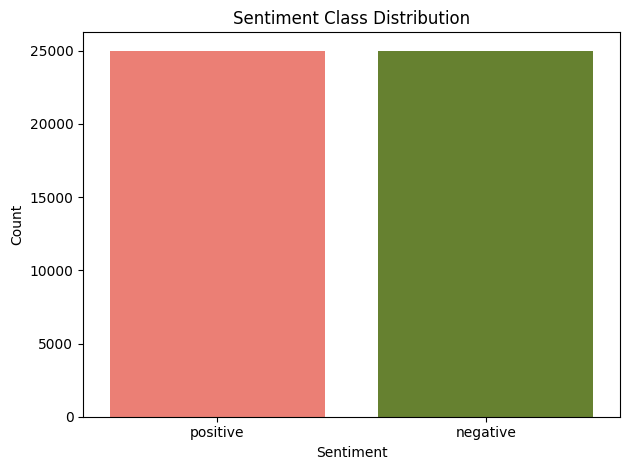

In [23]:
# Class Distribution Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette for negative and positive
custom_colors = ['#FF6F61', '#6B8E23']  # reddish for negative, greenish for positive

sns.countplot(x='sentiment', data=df, palette=custom_colors)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

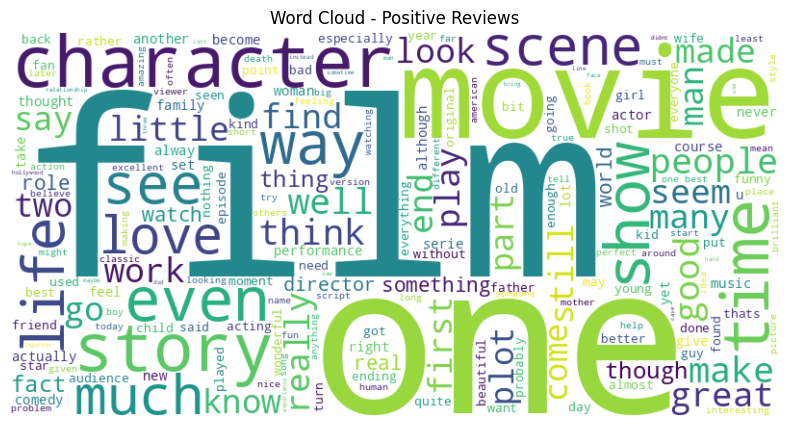

In [24]:
# Word Cloud of Positive and Negative Reviews
from wordcloud import WordCloud

# Word cloud for positive reviews
positive_text = ' '.join(df[df['sentiment'] == 'positive']['clean_review'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')
plt.show()

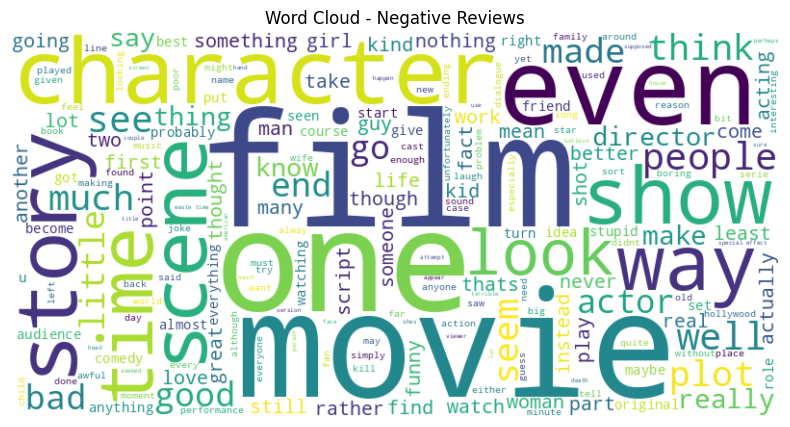

In [25]:
# Word cloud for negative reviews
negative_text = ' '.join(df[df['sentiment'] == 'negative']['clean_review'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews')
plt.show()

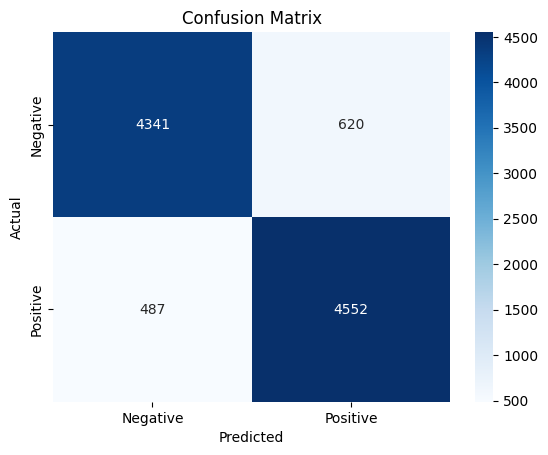

In [26]:
# Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

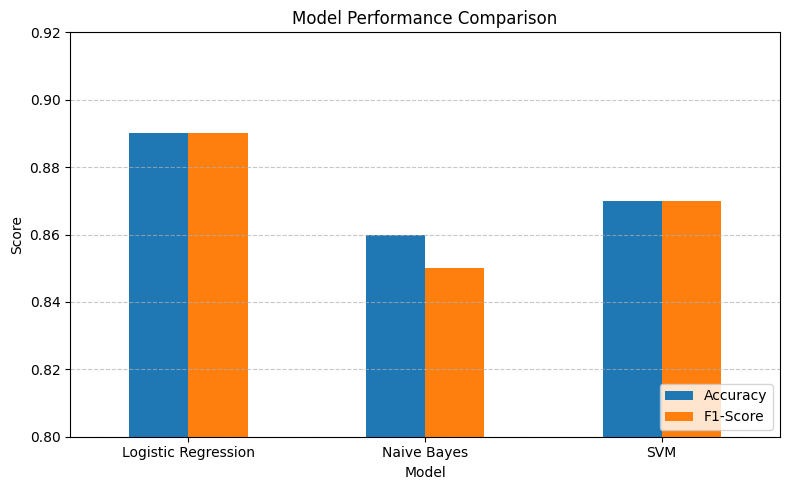

In [27]:
# Model Performance Comparison
model_scores = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM'],
    'Accuracy': [0.89, 0.86, 0.87],
    'F1-Score': [0.89, 0.85, 0.87]
})

# Plotting
ax = model_scores.plot(
    x='Model',
    y=['Accuracy', 'F1-Score'],
    kind='bar',
    figsize=(8, 5)
)

plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.80, 0.92)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_comparison.png')
plt.show()